<table>
  <tr>
      <td><div style="white-space: pre-wrap;" align="left"><font size="30" >Tutorial B2&#10;Motion Model </font></div></td>
     <td><img src="https://github.com/Tobias-Fischer/RVSS2022/blob/main/Spatial_Awareness/Tutorial_B2_Robot_Localisation/image/RVSS-logo.png?raw=1" width="400"></td>
  </tr>
</table>

## Imports

In [2]:
#Import all the necessary modules
import sys
import math
import numpy as np
import pickle

!git clone https://github.com/Tobias-Fischer/RVSS2022.git
os.chdir('RVSS2022/Spatial_Awareness/Tutorial_B2_Robot_Localisation')

#Visualizer
#from Renderer import *
#Here we import Robot class definition form the other notebook
from MotionModelRobot import *
#Here we import a class that defines out measurments
from Measurements import *

Cloning into 'RVSS2022'...
remote: Enumerating objects: 419, done.
remote: Counting objects: 100% (419/419), done.
remote: Compressing objects: 100% (343/343), done.
remote: Total 419 (delta 197), reused 258 (delta 68), pack-reused 0
Receiving objects: 100% (419/419), 30.22 MiB | 11.62 MiB/s, done.
Resolving deltas: 100% (197/197), done.


# 2. PenguinPi Kinematic Model


The state of the robot is described by its 2D position<!---$Latex Expression$ allows us to incorporate Latex Equations into the document---> $(x,y)$  and orientation $\theta$. Our control inputs are number of encoder ticks of the left and right wheels of the robot. We can convert the encoder ticks into linear $v$ and angular $w$ velocities of the robot.

We will create a <code>drive(self)</code> function that will update the current state of the robot<code>self.state=</code>$(x_k,y_k,\theta_k)$ to the next state $(x_{k+1},y_{k+1},\theta_{k+1})$ given control inputs.

The control inputs are provided through the sliders that will appear once a PenguinPi object is created

In [3]:
class PenguinPi(object):
    
    def __init__(self, wheels_width, wheels_scale):
        # State is a vector of [x,y,theta]'
        self.state = np.zeros((3,1))
        
        # Wheel parameters
        self.wheels_width = wheels_width  # The distance between the left and right wheels
        self.wheels_scale = wheels_scale  # The scaling factor converting ticks/s to m/s
            
    def drive(self, drive_meas):
        # left_speed and right_speed are the speeds in ticks/s of the left and right wheels.
        # dt is the length of time to drive for

        # Compute the linear and angular velocity from wheel speeds
        linear_velocity, angular_velocity = self.convert_wheel_speeds(drive_meas.left_speed, drive_meas.right_speed)

        #This is the current state of the robot
        x_k = self.state[0]
        y_k = self.state[1]
        theta_k = self.state[2]
        
        # Apply the velocities
        dt = drive_meas.dt
        if angular_velocity == 0:
#-----------------------------FILL OUT DRIVE STRAIGHT CODE-----------------------------
#
            x_kp1 = x_k + np.cos(theta_k)*linear_velocity*dt
            y_kp1 = y_k + np.sin(theta_k)*linear_velocity*dt
            theta_kp1 = theta_k
#
#--------------------------------------------------------------------------------------
        else:
#--------------------------------FILL OUT DRIVE CODE-----------------------------------
#
            R = linear_velocity / angular_velocity
            theta_kp1 = theta_k + angular_velocity*dt
            x_kp1 = x_k + R * (np.sin(theta_kp1) - np.sin(theta_k))
            y_kp1 = y_k + R * (-np.cos(theta_kp1) + np.cos(theta_k))
#
#--------------------------------------------------------------------------------------
       
        #Save our state 
        self.state[0] = x_kp1
        self.state[1] = y_kp1
        self.state[2] = theta_kp1
                        
            
    def convert_wheel_speeds(self, left_speed, right_speed):
        # Convert to m/s
        left_speed_m = left_speed * self.wheels_scale
        right_speed_m = right_speed * self.wheels_scale

        # Compute the linear and angular velocity
        linear_velocity = (left_speed_m + right_speed_m) / 2.0
        angular_velocity = (right_speed_m - left_speed_m) / self.wheels_width
        
        return linear_velocity, angular_velocity

## Test Driving Straight

In [4]:
#Test our drive function driving straight
#Creater a new robot object with wheel width of 15cm and 1cm per wheel tick
bot = Robot(0.15, 0.01)
#Place the robot at -2.8,-2.8 which is bottom middle of our arena
bot.state = np.array([[-2.8],[-2.8],[np.pi/4]])
#This is our control signal
#Create a measurement object to drive the robot in a straight line
# Set robot velocity
left_speed, right_speed = 10, 10
# Set the sampling rate
dt = 0.2
drive_meas = DriveMeasurement(left_speed, right_speed, dt)

N = 200
state  = np.zeros((N,3))
for c in range(state.shape[0]):
    state[c,:] = bot.state[:,0]
    bot.drive(drive_meas)
#Create a visualizer and visualize our state
#rend = Rendered.Instance()
#rend.initialize(state)


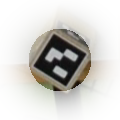
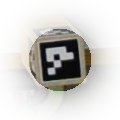
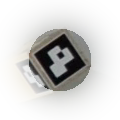
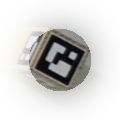
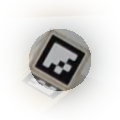
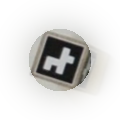
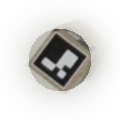
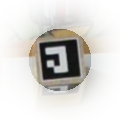
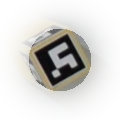
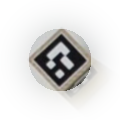

In [19]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import os
from PIL import Image

def arrowx(x,theta,size):
  c=np.cos(theta)
  s=np.sin(theta)
  return[x,
         x+c*size,
         x+(0.75*c-0.15*s)*size,
         None,
         x+c*size,
         x+(0.75*c+0.15*s)*size]

def arrowy(y,theta,size):
  s=np.sin(theta)
  c=np.cos(theta)
  return[y,
          y+s*size,
          y+(0.75*s+0.15*c)*size,
          None,
          y+s*size,
          y+(0.75*s-0.15*c)*size]

def robot(state):
  arrowsize=0.1
  rx=[]
  ry=[]
  ra=[]
  rc=[]
  for t in range(state.shape[0]):
    x=state[t,0]
    y=state[t,1]
    theta=state[t,2]
    rx+=arrowx(x,theta,arrowsize)
    ry+=arrowy(y,theta,arrowsize)
    ra+=[t]*6
    rc+=['r']*6
    rx+=arrowx(x,theta+np.pi/2,arrowsize)
    ry+=arrowy(y,theta+np.pi/2,arrowsize)
    ra+=[t]*6
    rc+=['g']*6
  return rx,ry,ra,rc

def Render(state):
  x,y,a,c = robot(state)

  colmap={'r':'red','g':'green'}
  fig = px.line(x=x,y=y,animation_frame=a, color=c, color_discrete_map=colmap)

  marker_files = [filename for filename in os.listdir('./image') if filename.startswith("M")]
  marker_world_width = 0.3
  for i,filename in enumerate(marker_files):
    fprts = filename.split('_')
    xpos = float(fprts[1])
    ypos = float(fprts[2])
    #mp = np.array([float(fprts[1]),float(fprts[2])])
    #mi = cv2.imread('./image/'+filename)
    im = Image.open('image/' + filename)
    imsize = 0.3
    # Add images
    fig.add_layout_image(
        dict(
            source = im,
            xref="x",
            yref="y",
            x=xpos-imsize/2,
            y=ypos+imsize/2,
            sizex=imsize,
            sizey=imsize,
            sizing="contain",
            opacity=1.0,
            layer="below")
    )

  fig.update_xaxes(showgrid=False, range = [-4,-2])
  fig.update_yaxes(showgrid=False, range = [-3.5,-1.5])
  fig.update_layout(template="plotly_white")
  fig.update_layout(width = 500, height=530) #makes it look square on my screen
  fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 100
  fig.show()

Render(state)

## Test Driving in a Circle


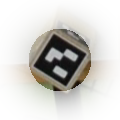
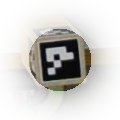
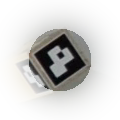
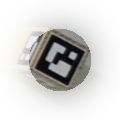
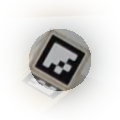
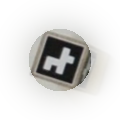
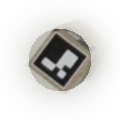
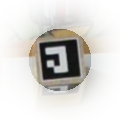
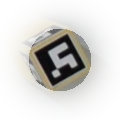
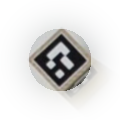

In [17]:
#Test our drive function
#Place the robot at -2.8,-2.8 which is bottom middle of our arena
bot.state = np.array([[-2.8],[-2.8],[0]])

#This is our control signal
#Create a measurement object to drive the robot in a circle
# Set robot velocity
left_speed, right_speed = 10, 14
# Set the sampling rate
dt = 0.2
drive_meas = DriveMeasurement(left_speed, right_speed, dt)

N = 200
state  = np.zeros((N,3))
for c in range(state.shape[0]):
    state[c,:] = bot.state[:,0]
    bot.drive(drive_meas)

#Create a visualizer and visualize our state
#rend = Rendered.Instance()
#rend.initialize(state)
Render(state)

## Test Driving Real Data

In [ ]:
#Finally test our robot with some real data

#Here we load our data including the true state 
with open('data/data.dat', "rb") as f:
    data = pickle.load(f)
    
gt_state = data['state'][48:,:]
control = data['control'][48:,:]

bot = Robot(0.15, 0.01)
bot.state = np.array([[-2.8],[-2.8],[0]])
#Place the robot at the correct initial state X0
bot.state = gt_state[0,:].copy().reshape(-1,1)

#Apply our control to the robot and visualize
#Our timestamp is always 0.2
dt = 0.2
#Here we will save our state variable 
state = np.zeros((control.shape[0],3))

for c in range(control.shape[0]):
    state[c,:] = bot.state[:,0]
    drive_signal = DriveMeasurement(control[c,0],control[c,1],dt)
    bot.drive(drive_signal)

#Create a visualizer and visualize our state
rend = Rendered.Instance()
rend.initialize(state,gt_state = gt_state)


In [ ]:
gt_state[48:,:]

In [ ]:
time = np.arange(0,control.shape[0])*dt
plt.figure()
plt.plot(time,control[:,0])
plt.plot(time,control[:,1])
